# Regression after Unsmoothing on Google Trend Data

This notebook would use Li2CO3 data from investing.com (which totally have data from 2018 to 2023) and the unit is CNY/TON. 

Google Trend Data is generated from https://trends.google.com/trends/explore?date=2018-09-07%202023-11-03&gprop=news&q=lithium,EV,%2Fm%2F01pmdg,%2Fm%2F01c0z,Energy&hl=en. 

I only focus on `new search` instead of `web search`. The each cell in the google trend is the number of search. 

Lithium Price is sampled every Sunday which is consistent with the Google data. 

In [2]:
import warnings 
warnings.filterwarnings('ignore')
from utils.utils import transform_data, plot_correlogram, get_stock_data
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.tsa.arima.model as tsa

In [78]:
help(transform_data)

Help on function transform_data in module utils.utils:

transform_data(file_path, sampling_period='W-FRI')
    This function transform the price into log return and output the weekly log return and price in a dataframe.



In [4]:
li2co3 = transform_data("../data/Lithium Carbonate 99%Min China Spot Historical Data2.csv", sampling_period='W-SUN')

         Date       Price        Open        High         Low  Vol. Change %
0  11/10/2023  144,500.00  144,500.00  147,000.00  142,000.00   NaN   -2.03%
1  11/09/2023  147,500.00  147,500.00  150,000.00  145,000.00   NaN    0.00%
2  11/08/2023  147,500.00  147,500.00  150,000.00  145,000.00   NaN   -1.34%
3  11/07/2023  149,500.00  149,500.00  152,000.00  147,000.00   NaN   -2.61%
4  11/06/2023  153,500.00  153,500.00  156,000.00  151,000.00   NaN   -0.65%


Please enter the column names, separated by a comma:  Date, Price, 1, 2,3,4, 5


<AxesSubplot: xlabel='Date'>

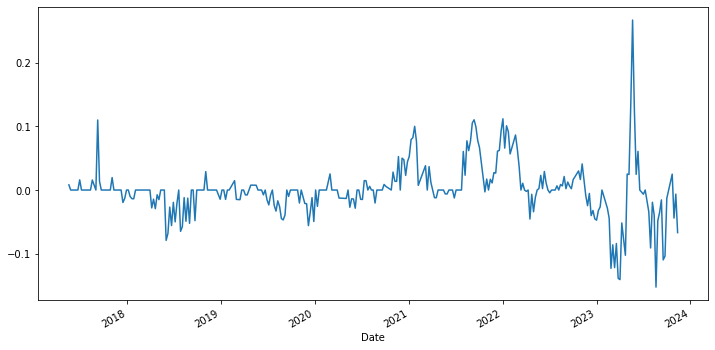

In [5]:
# Specify the size of the figure
plt.figure(figsize=(12, 6))
li2co3.Log_Return.plot()

In [6]:
# ro is observed data
ro = li2co3.Log_Return

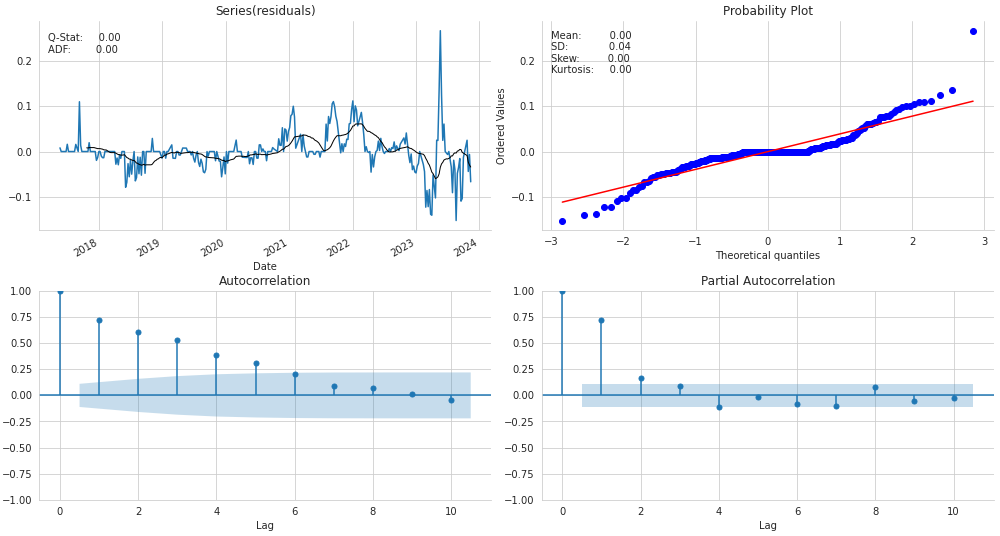

In [7]:
plot_correlogram(ro)

## AR(p = 1) 

In [102]:
# ro_stationary 

AR_1_result = tsa.ARIMA(ro,order=(1,0,0)).fit()
a, b, std = AR_1_result.params
theta = b 
mu = a/(1-b)
et = AR_1_result.resid/(1-b)
fitted = mu + et

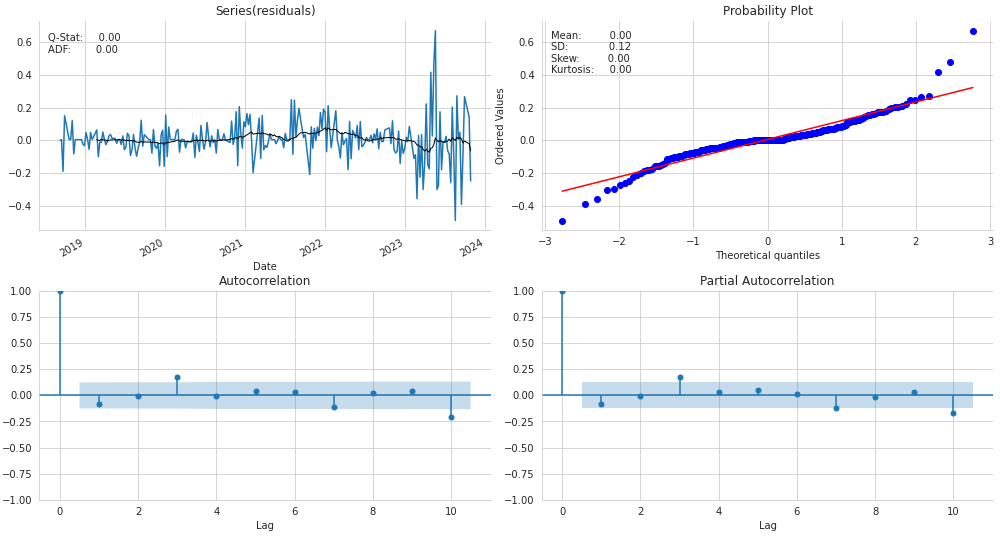

In [103]:
plot_correlogram(fitted)

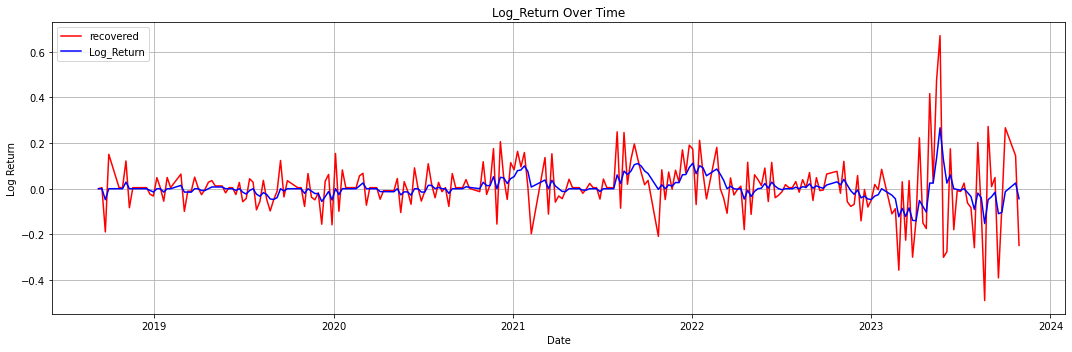

In [104]:
# plot fitted and original one: 

# Separate plot for 'Log_Return' for clarity and because it might be on a different scale
plt.figure(figsize=(15, 5))
plt.plot(ro.index, fitted, label="recovered", color="red")
plt.plot(ro.index, ro, label="Log_Return", color="blue")
plt.title("Log_Return Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

## Regression on Google Trend

In [32]:
import pandas as pd
google_trend = pd.read_csv('../data/google_trend2.csv')

In [33]:
cols = list(google_trend.iloc[0,:].name)
df_google_trend = pd.DataFrame(columns = cols)

for i in range(1,len(google_trend)):
# Convert the string to a datetime object.
    dt = pd.to_datetime(google_trend.iloc[i,:].name[0])
    f1 = int(google_trend.iloc[i,:].name[1])
    f2 = int(google_trend.iloc[i,:].name[2])
    f3 = int(google_trend.iloc[i,:].name[3])
    f4 = int(google_trend.iloc[i,:].name[4])

    dic = {'Week': dt, 'lithium: (Worldwide)': f1, 'EV: (Worldwide)': f2, \
       'Electric vehicle: (Worldwide)': f3, 'Electric battery: (Worldwide)': f4}
    df_google_trend = df_google_trend.append(dic, ignore_index=True)

In [34]:
df_google_trend.columns = ['Week', 'lithium', 'EV', 'electric_vechile', 'Electric battery']

In [35]:
df_ro = pd.DataFrame(ro)
df_reg_on_trend = df_google_trend.merge(df_ro, left_on = 'Week', right_on = 'Date', how = 'right')

In [36]:
df_reg_on_trend['lithium_lag'] = df_reg_on_trend.lithium.diff()

In [37]:
df_reg_on_trend['EV_lag'] = df_reg_on_trend.EV.diff()
df_reg_on_trend['electric_vechile_lag'] = df_reg_on_trend.electric_vechile.diff()
df_reg_on_trend['Electric_battery_lag'] = df_reg_on_trend['Electric battery'].diff()

In [39]:
df_reg_on_trend = df_reg_on_trend.dropna()

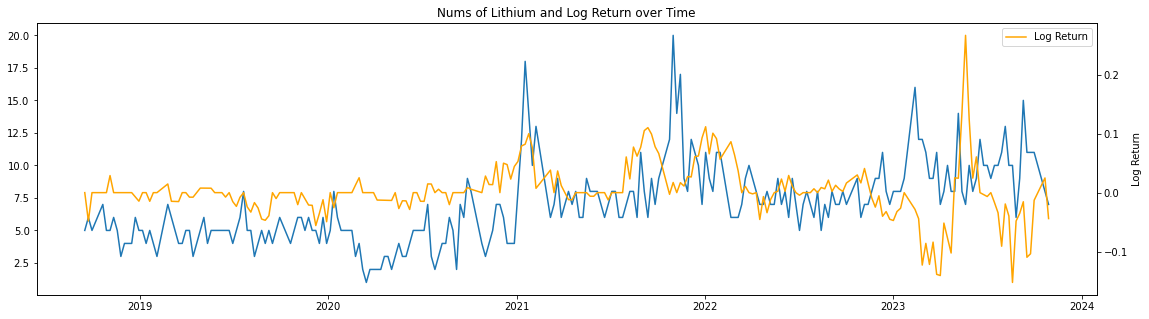

In [47]:
import matplotlib.pyplot as plt

# Assuming df_reg_on_gdelt is your DataFrame and it has 'week_friday', 'max', and 'Log_Return' columns

plt.figure(figsize=(19, 5))

# Plot the first line with 'max' on the left y-axis
plt.plot(df_reg_on_trend['Week'], df_reg_on_trend['lithium'], label='lithium')

# Create a second y-axis that shares the same x-axis
ax2 = plt.twinx()

# Plot the second line with 'Log_Return' on the right y-axis
ax2.plot(df_reg_on_trend['Week'], df_reg_on_trend['Log_Return'], label='Log Return', color='orange')

# Optionally, add labels, title, and legend
plt.title('Nums Searching of Lithium and Log Return over Time')
plt.xlabel('Date')
plt.ylabel('Max')
ax2.set_ylabel('Log Return')

# Adding legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

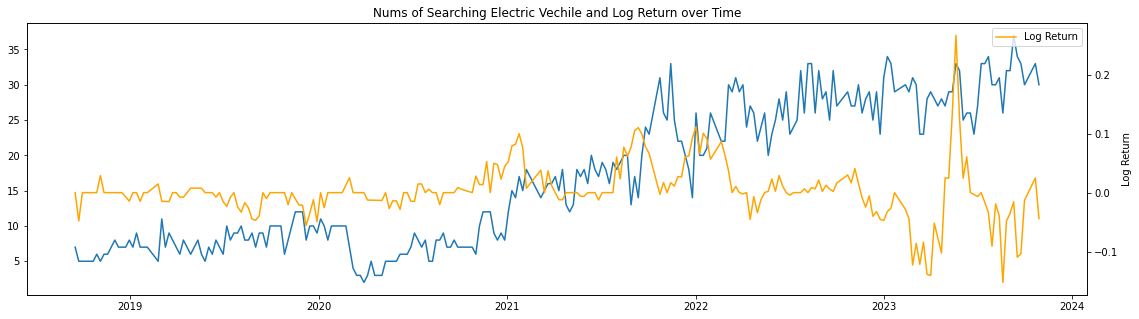

In [51]:
import matplotlib.pyplot as plt

# Assuming df_reg_on_gdelt is your DataFrame and it has 'week_friday', 'max', and 'Log_Return' columns

plt.figure(figsize=(19, 5))

# Plot the first line with 'max' on the left y-axis
plt.plot(df_reg_on_trend['Week'], df_reg_on_trend['electric_vechile'], label='EV')

# Create a second y-axis that shares the same x-axis
ax2 = plt.twinx()

# Plot the second line with 'Log_Return' on the right y-axis
ax2.plot(df_reg_on_trend['Week'], df_reg_on_trend['Log_Return'], label='Log Return', color='orange')

# Optionally, add labels, title, and legend
plt.title('Nums of Searching Electric Vechile and Log Return over Time')
plt.xlabel('Date')
plt.ylabel('Max')
ax2.set_ylabel('Log Return')

# Adding legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

## Simple Linear Regression 

In [44]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X_train = df_reg_on_trend[['lithium', 'Electric battery', 'EV',\
       'electric_vechile']].iloc[0:, :]
y_train = df_reg_on_trend['Log_Return'][0:]
y_train = y_train.reset_index(drop=True)
X_test = df_reg_on_trend[['lithium', 'Electric battery', 'EV',\
       'electric_vechile']].iloc[150:, :]
y_test = df_reg_on_trend['Log_Return'][150:]
y_test = y_test.reset_index(drop=True)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

import statsmodels.api as sm

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

X_train_scaled_sm = sm.add_constant(X_train_scaled)

# Create a model
model_sm = sm.OLS(y_train, X_train_scaled_sm)

# Fit the model
results = model_sm.fit()

# Get the summary of the regression
summary = results.summary()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.501
Date:                Fri, 10 Nov 2023   Prob (F-statistic):             0.0432
Time:                        18:58:31   Log-Likelihood:                 414.62
No. Observations:                 245   AIC:                            -819.2
Df Residuals:                     240   BIC:                            -801.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0156      0.009  

In [213]:
# Add a constant to the scaled test data
X_test_scaled_sm = sm.add_constant(X_test_scaled)

# Use the trained model to make predictions on the scaled test data
y_test_pred = results.predict(X_test_scaled_sm)

# Calculate the actual direction of change
actual_changes = np.sign(np.diff(y_test))

# Calculate the predicted direction of change
predicted_changes = np.sign(np.diff(y_test_pred))

# Calculate the hit rate
hits = np.sum(actual_changes == predicted_changes)
total_predictions = len(actual_changes)

# Hit rate
hit_rate = hits / total_predictions

hit_rate

0.6190476190476191

## Adding Polynomial Terms

In [203]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction = poly.fit_transform(X_train)
# Get the names of the features created
interaction_feature_names = poly.get_feature_names(X_train.columns)


scaler_interaction = MinMaxScaler()
X_train_interaction_scaled = scaler_interaction.fit_transform(X_train_interaction)
X_train_interaction_scaled = pd.DataFrame(X_train_interaction_scaled, columns = interaction_feature_names)

X_train_interaction_scaled_sm = sm.add_constant(X_train_interaction_scaled)

model_interaction_sm = sm.OLS(y_train, X_train_interaction_scaled_sm)

results_interaction = model_interaction_sm.fit()

summary_interaction = results_interaction.summary()
print(summary_interaction)


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     5.959
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.77e-07
Time:                        17:08:57   Log-Likelihood:                 272.71
No. Observations:                 150   AIC:                            -523.4
Df Residuals:                     139   BIC:                            -490.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [209]:
# First, we will transform the test data using the same PolynomialFeatures and scaler as the training data
X_test_interaction = poly.transform(X_test)
X_test_interaction_scaled = scaler_interaction.transform(X_test_interaction)
X_test_interaction_scaled_df = pd.DataFrame(X_test_interaction_scaled, columns=interaction_feature_names)

# Add a constant to the scaled test data
X_test_interaction_scaled_sm = sm.add_constant(X_test_interaction_scaled_df)

# Use the trained model to make predictions on the scaled test data
y_test_pred = results_interaction.predict(X_test_interaction_scaled_sm)

# Assume y_test contains the actual returns and y_test_pred contains the predicted returns
# Calculate the actual direction of change
actual_direction = np.sign(y_test - y_test.shift(1))

# Calculate the predicted direction of change
predicted_direction = np.sign(y_test_pred - y_test.shift(1))

# Remove the first element since it will be NaN after the shift
actual_direction = actual_direction[1:]
predicted_direction = predicted_direction[1:]

# Calculate the number of correct predictions
correct_predictions = np.sum(actual_direction == predicted_direction)

# Calculate the hit rate
hit_rate = correct_predictions / len(actual_direction)

hit_rate



0.6190476190476191

In [207]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_interaction = poly.fit_transform(X_train)
# Get the names of the features created
interaction_feature_names = poly.get_feature_names(X_train.columns)


scaler_interaction = MinMaxScaler()
X_train_interaction_scaled = scaler_interaction.fit_transform(X_train_interaction)
X_train_interaction_scaled = pd.DataFrame(X_train_interaction_scaled, columns = interaction_feature_names)

X_train_interaction_scaled_sm = sm.add_constant(X_train_interaction_scaled)

model_interaction_sm = sm.OLS(y_train, X_train_interaction_scaled_sm)

results_interaction = model_interaction_sm.fit()

summary_interaction = results_interaction.summary()
print(summary_interaction)


                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     5.760
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.06e-08
Time:                        17:15:53   Log-Likelihood:                 281.08
No. Observations:                 150   AIC:                            -532.2
Df Residuals:                     135   BIC:                            -487.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [208]:
# To evaluate the model, we'll first need to transform the test data in the same way we did the training data
# Create the squared terms and interaction terms for the test set
X_test_poly = poly.transform(X_test_scaled)

# Convert to a DataFrame with the appropriate feature names
X_test_poly_df = pd.DataFrame(X_test_poly)

# Add a constant to the DataFrame for the intercept
X_test_poly_with_constant = sm.add_constant(X_test_poly_df)

# Use the fitted model to make predictions on the test set
y_pred = results_interaction.predict(X_test_poly_with_constant)

# Assume y_test contains the actual returns and y_test_pred contains the predicted returns
# Calculate the actual direction of change
actual_direction = np.sign(y_test - y_test.shift(1))

# Calculate the predicted direction of change
predicted_direction = np.sign(y_pred - y_test.shift(1))

# Remove the first element since it will be NaN after the shift
actual_direction = actual_direction[1:]
predicted_direction = predicted_direction[1:]

# Calculate the number of correct predictions
correct_predictions = np.sum(actual_direction == predicted_direction)

# Calculate the hit rate
hit_rate = correct_predictions / len(actual_direction)

hit_rate


0.6190476190476191